In [ ]:
#importing all the required libraries
!pip install category_encoders
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import category_encoders as ce
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns',None)
plt.style.use('fivethirtyeight')
from google.colab import drive
# have used google colab to execute the python script. Hence mounting the files through my drive
drive.mount('/drive')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


In [ ]:
#accessing the files
data = pd.read_csv('/drive/My Drive/641 project/Travel details dataset.csv')
data.rename(columns={'Start date':'Start','End date':'End','Duration (days)':'Duration','Traveler name':'name','Traveler age':'age','Traveler gender':'gender','Traveler nationality':'nationality'},inplace=True)
data.head()

,Trip ID,Destination,Start,End,Duration,name,age,gender,nationality,Accommodation type,Accommodation cost,Transportation type,Transportation cost
0,1,"London, UK",5/1/2023,5/8/2023,7.0,John Smith,35.0,Male,American,Hotel,1200,Flight,600
1,2,"Phuket, Thailand",6/15/2023,6/20/2023,5.0,Jane Doe,28.0,Female,Canadian,Resort,800,Flight,500
2,3,"Bali, Indonesia",7/1/2023,7/8/2023,7.0,David Lee,45.0,Male,Korean,Villa,1000,Flight,700
3,4,"New York, USA",8/15/2023,8/29/2023,14.0,Sarah Johnson,29.0,Female,British,Hotel,2000,Flight,1000
4,5,"Tokyo, Japan",9/10/2023,9/17/2023,7.0,Kim Nguyen,26.0,Female,Vietnamese,Airbnb,700,Train,200


<Axes: >

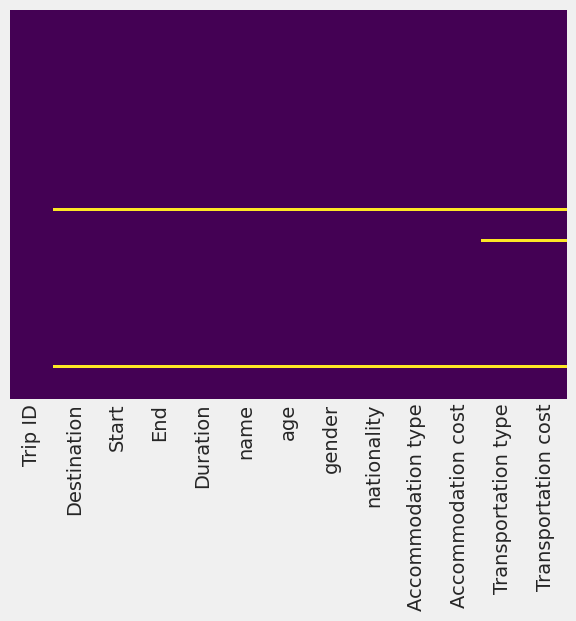

In [ ]:
#Heatmap for all the columns
sns.heatmap(data.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [ ]:
data = data.dropna() # drop the rows with missing values

In [ ]:
# Convert Transportation cost to numeric
data['Transportation cost'] = pd.to_numeric(data['Transportation cost'].astype(str).str.replace('[$,USD]', ''))

# Convert Accomadation cost to numeric
data['Accommodation cost'] = pd.to_numeric(data['Accommodation cost'].astype(str).str.replace('[$,USD]', ''))

# Check updated data types
print(data.dtypes)


Trip ID                  int64
Destination             object
Start                   object
End                     object
Duration               float64
name                    object
age                    float64
gender                  object
nationality             object
Accommodation type      object
Accommodation cost       int64
Transportation type     object
Transportation cost      int64
dtype: object


In [ ]:
#dropping the missing values 
data.isnull().sum() # check the number of missing values in each column
data = data.dropna() # drop the rows with missing values



In [ ]:
#merging different Transportation type into specific category
data['Transportation type'] = data['Transportation type'].str.replace('Flight', 'Airplane')
data['Transportation type'] = data['Transportation type'].str.replace('Plane', 'Airplane')

print(data['Transportation type'].value_counts())


Airplane      75
Train         37
Car rental    13
Bus            6
Car            3
Subway         1
Ferry          1
Name: Transportation type, dtype: int64


In [ ]:
# creating a dictionary to map similar types of accommodation together
mapping = {
    'Hotel': 'Luxury Hotel',
    'Resort': 'Luxury Hotel',
    'Villa': 'Luxury Hotel',
    'Riad': 'Luxury Hotel',
    'Airbnb': 'Budget-friendly',
    'Hostel': 'Budget-friendly',
    'Vacation rental': 'Budget-friendly',
    'Guesthouse': 'Budget-friendly'
}

# grouping similar types of accommodation together
data['Accommodation type'] = data['Accommodation type'].map(mapping)

# combining infrequent values into an "Other" category
data.loc[~data['Accommodation type'].isin(['Luxury Hotel', 'Budget-friendly']), 'Accommodation type'] = 'Other'

# print the value counts of the new column
print(data['Accommodation type'].value_counts())


Luxury Hotel       78
Budget-friendly    58
Name: Accommodation type, dtype: int64


In [ ]:
# creating a dictionary to map similar types of transportation together
mapping = {
    'Airplane': 'Air',
    'Train': 'Rail',
    'Bus': 'Road',
    'Car rental': 'Road',
    'Car' : 'Road',
    'Subway': 'Rail',
    'Ferry': 'Water'
}

# group similar types of transportation together
data['Transportation type'] = data['Transportation type'].map(mapping)

# combine infrequent values into an "Other" category
data.loc[~data['Transportation type'].isin(['Air', 'Rail', 'Road', 'Water']), 'Transportation type'] = 'Other'

# print the value counts of the new column
print(data['Transportation type'].value_counts())


Air      75
Rail     38
Road     22
Water     1
Name: Transportation type, dtype: int64


In [ ]:
# Split the Destination column at the comma, and keep only the first element
data['Destination'] = data['Destination'].str.split(',').str[0]

In [ ]:
# Convert 'Transportation Cost' and 'Accommodation Cost' to numeric format
data['Transportation cost'] = pd.to_numeric(data['Transportation cost'], errors='coerce')
data['Accommodation cost'] = pd.to_numeric(data['Accommodation cost'], errors='coerce')
data['Total Cost'] = data['Accommodation cost'] + data['Transportation cost']
data

,Trip ID,Destination,Start,End,Duration,name,age,gender,nationality,Accommodation type,Accommodation cost,Transportation type,Transportation cost,Total Cost
0,1,London,5/1/2023,5/8/2023,7.0,John Smith,35.0,Male,American,Luxury Hotel,1200,Air,600,1800
1,2,Phuket,6/15/2023,6/20/2023,5.0,Jane Doe,28.0,Female,Canadian,Luxury Hotel,800,Air,500,1300
2,3,Bali,7/1/2023,7/8/2023,7.0,David Lee,45.0,Male,Korean,Luxury Hotel,1000,Air,700,1700
3,4,New York,8/15/2023,8/29/2023,14.0,Sarah Johnson,29.0,Female,British,Luxury Hotel,2000,Air,1000,3000
4,5,Tokyo,9/10/2023,9/17/2023,7.0,Kim Nguyen,26.0,Female,Vietnamese,Budget-friendly,700,Rail,200,900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134,135,Rio de Janeiro,8/1/2023,8/10/2023,9.0,Jose Perez,37.0,Male,Brazilian,Budget-friendly,2500,Road,2000,4500
135,136,Vancouver,8/15/2023,8/21/2023,6.0,Emma Wilson,29.0,Female,Canadian,Luxury Hotel,5000,Air,3000,8000
136,137,Bangkok,9/1/2023,9/8/2023,7.0,Ryan Chen,34.0,Male,Chinese,Budget-friendly,2000,Rail,1000,3000
137,138,Barcelona,9/15/2023,9/22/2023,7.0,Sofia Rodriguez,25.0,Female,Spanish,Budget-friendly,6000,Air,2500,8500


In [ ]:
# Define a dictionary that maps each country to its corresponding continent
continent_mapping = {'Spain': 'Europe',
                     'France': 'Europe',
                     'Italy': 'Europe',
                     'Tokyo': 'Asia',
                     'Thailand': 'Asia',
                     'USA': 'North America',
                     'Mexico': 'North America',
                     'Sydney': 'Oceania',
                     'Bali' : "Asia",
                     'Vancouver': 'North America',
                     'Barcelona' : 'Europe',
                     'Rio de Janeiro' : 'South America',
                     'Bangkok' : 'Asia',
                     'Cancun' : 'North America',
                     'Cape Town' : 'Africa',
                     'Rome' : 'Europe',
                     'Phuket' : 'Asia',
                     'Dubai' : 'Asia',
                     'Santorini' : 'Europe',
                     'Seoul' : 'Asia',
                     'Amsterdam' : 'Europe',
                     'Bangkok' : 'Asia',
                     'Los Angeles' : 'North America',
                     'Honolulu' : 'North America',
                     'Berlin' : 'Europe',
                     'Marrakech' : 'Africa',
                     'Edinburgh' : 'Europe',
                     'Brazil' : 'South America',
                     'Greece' : 'Europe',
                     'Egypt' : 'Africa',
                     'Auckland' : 'Oceania',
                     'Italy' : 'Europe',
                     'Phnom Penh' : 'Asia',
                     'Paris' : 'Europe',
                     'New York' : 'North America',
                     'London' : 'Europe',
                     'Rome' : 'Europe',
                     'New York City' : 'North America',
                     'Athens' : 'Europe',
                     'Australia' : 'Oceania',
                     'Canada' : 'North America',
                     'Spain' : 'Europe',
                     'Hawaii' : 'North America',
                     'Japan' : 'Asia'

                     }

# Create a new column in the DataFrame with the continent for each destination
data['Continent'] = data['Destination'].map(continent_mapping)

# Count the number of trips per continent
trips_per_continent = data['Continent'].value_counts()

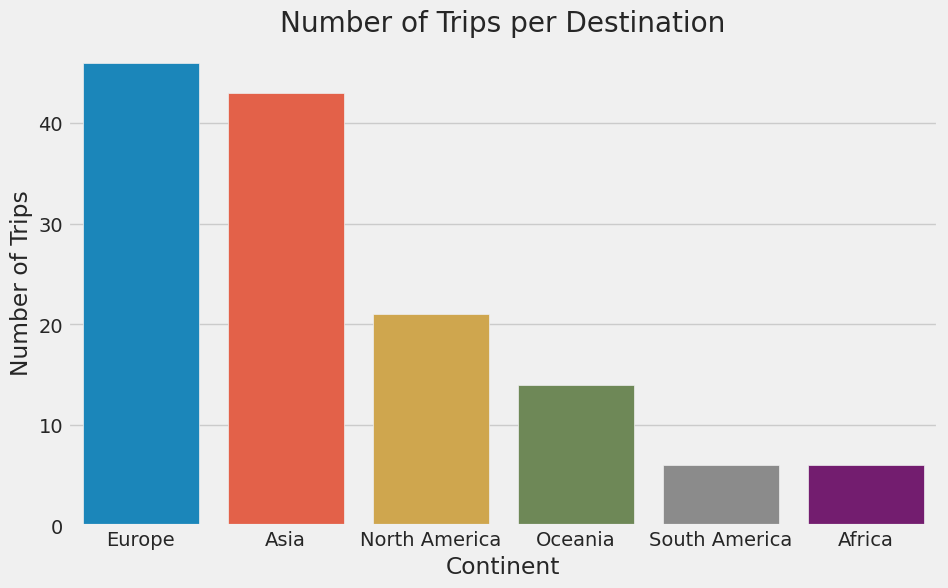

In [ ]:
# Count the number of trips per destination
trips_per_destination = data['Continent'].value_counts()
plt.figure(figsize=(10, 6))
sns.barplot(x=trips_per_destination.index, y=trips_per_destination.values)
plt.title('Number of Trips per Destination')
plt.xlabel('Continent')
plt.ylabel('Number of Trips')
plt.show()


In [ ]:
data

,Trip ID,Destination,Start,End,Duration,name,age,gender,nationality,Accommodation type,Accommodation cost,Transportation type,Transportation cost,Total Cost,Continent
0,1,London,5/1/2023,5/8/2023,7.0,John Smith,35.0,Male,American,Luxury Hotel,1200,Air,600,1800,Europe
1,2,Phuket,6/15/2023,6/20/2023,5.0,Jane Doe,28.0,Female,Canadian,Luxury Hotel,800,Air,500,1300,Asia
2,3,Bali,7/1/2023,7/8/2023,7.0,David Lee,45.0,Male,Korean,Luxury Hotel,1000,Air,700,1700,Asia
3,4,New York,8/15/2023,8/29/2023,14.0,Sarah Johnson,29.0,Female,British,Luxury Hotel,2000,Air,1000,3000,North America
4,5,Tokyo,9/10/2023,9/17/2023,7.0,Kim Nguyen,26.0,Female,Vietnamese,Budget-friendly,700,Rail,200,900,Asia
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134,135,Rio de Janeiro,8/1/2023,8/10/2023,9.0,Jose Perez,37.0,Male,Brazilian,Budget-friendly,2500,Road,2000,4500,South America
135,136,Vancouver,8/15/2023,8/21/2023,6.0,Emma Wilson,29.0,Female,Canadian,Luxury Hotel,5000,Air,3000,8000,North America
136,137,Bangkok,9/1/2023,9/8/2023,7.0,Ryan Chen,34.0,Male,Chinese,Budget-friendly,2000,Rail,1000,3000,Asia
137,138,Barcelona,9/15/2023,9/22/2023,7.0,Sofia Rodriguez,25.0,Female,Spanish,Budget-friendly,6000,Air,2500,8500,Europe


In [ ]:
#Drop the uneccssary columns
data =data.drop(['Trip ID','Destination','End','Start','name'], axis=1)

In [ ]:
#converting all the columns to specific data type for further analysis
data['Accommodation cost'] = data['Accommodation cost'].astype(float)
data['Transportation cost'] = data['Transportation cost'].astype(float)
data['Total Cost'] = data['Total Cost'].astype(float)

<Axes: >

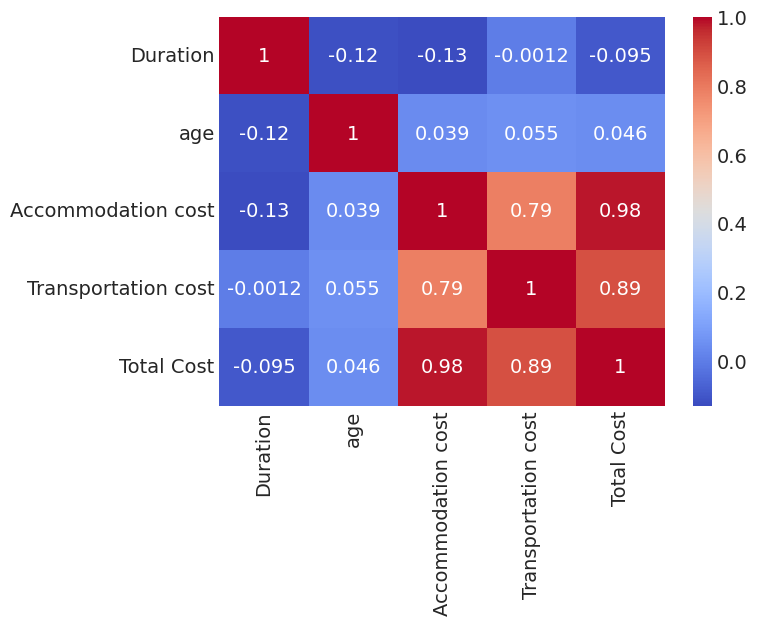

In [ ]:
#correlation matrix
sns.set_style('whitegrid')
sns.heatmap(data.corr(),annot=True,cmap='coolwarm')

<Axes: xlabel='gender', ylabel='age'>

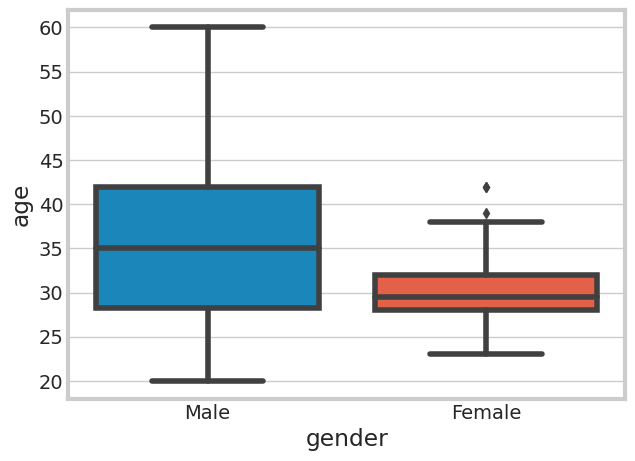

In [ ]:
#boxplot using seaborn to visualize the distribution of age across different values of the gender column in the given dataset.
sns.boxplot(data=data,x='gender',y='age')

In [ ]:
data.groupby('gender')['age'].agg(['mean','max','min'])

,mean,max,min
gender,,,
Female,30.328571,42.0,23.0
Male,36.075758,60.0,20.0


In [ ]:
#Most visited Country
data['Continent'].value_counts().sort_values(ascending=False).head(5)


Europe           46
Asia             43
North America    21
Oceania          14
South America     6
Name: Continent, dtype: int64

Text(0.5, 1.0, 'Top10 costliest Continents (in terms of Accommodation)')

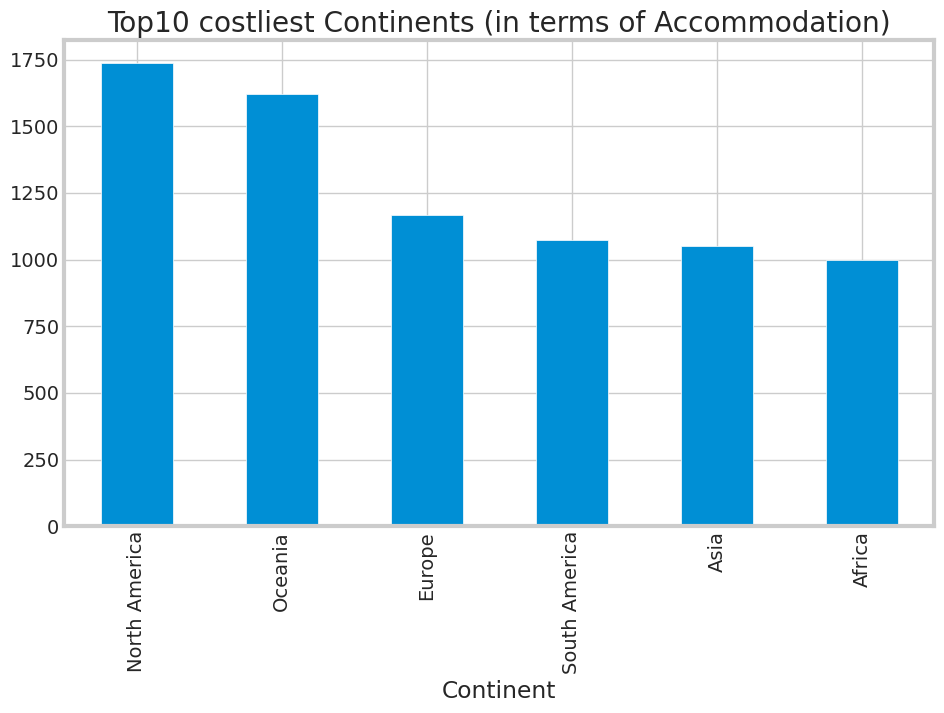

In [ ]:
#Bar plot for top 10 costiest Continents
plt.figure(figsize=(10,6))
data.groupby('Continent')['Accommodation cost'].agg('mean').nlargest(10).plot(kind='bar')
plt.title('Top10 costliest Continents (in terms of Accommodation)')

Air      75
Rail     38
Road     22
Water     1
Name: Transportation type, dtype: int64


Text(0.5, 1.0, 'Transportation Types')

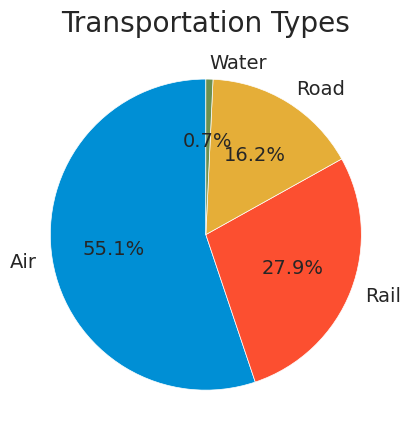

In [ ]:
#top 5 preferred way to travel
a=data['Transportation type'].value_counts().sort_values(ascending=False).head(5)
print(a)
a.plot(kind='pie',autopct='%0.1f%%',startangle=90)
plt.ylabel('')
plt.title('Transportation Types')

Luxury Hotel       78
Budget-friendly    58
Name: Accommodation type, dtype: int64


Text(0.5, 1.0, 'Accommodation Types')

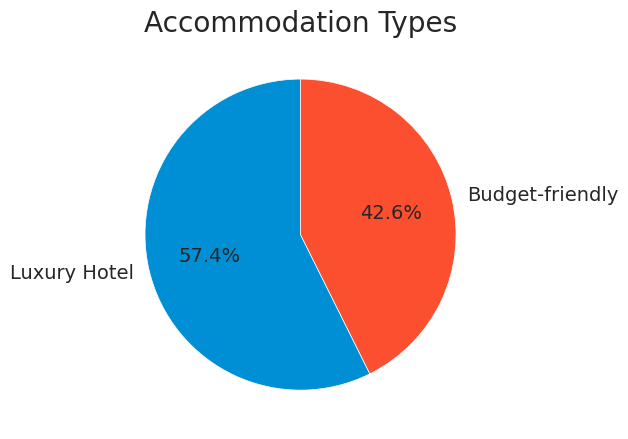

In [ ]:
#top 5 preferred accommodation
a=data['Accommodation type'].value_counts().sort_values(ascending=False).head(5)
print(a)
a.plot(kind='pie',autopct='%0.1f%%',startangle=90)
plt.ylabel('')
plt.title('Accommodation Types')

Text(0.5, 1.0, 'Most liked Contients to visit by Americans')

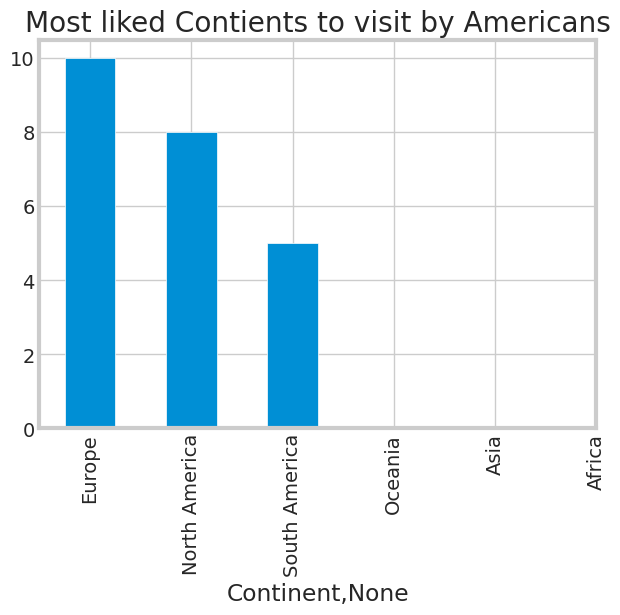

In [ ]:
#Most liked Continents to visit by Americans
df=pd.DataFrame(data.groupby('nationality')['Continent'].value_counts())
df.stack()['American'].plot(kind='bar')
plt.xticks(range(0,6),['Europe','North America','South America','Oceania','Asia','Africa'])
plt.title('Most liked Contients to visit by Americans')

In [ ]:
data

,Duration,age,gender,nationality,Accommodation type,Accommodation cost,Transportation type,Transportation cost,Total Cost,Continent
0,7.0,35.0,Male,American,Luxury Hotel,1200.0,Air,600.0,1800.0,Europe
1,5.0,28.0,Female,Canadian,Luxury Hotel,800.0,Air,500.0,1300.0,Asia
2,7.0,45.0,Male,Korean,Luxury Hotel,1000.0,Air,700.0,1700.0,Asia
3,14.0,29.0,Female,British,Luxury Hotel,2000.0,Air,1000.0,3000.0,North America
4,7.0,26.0,Female,Vietnamese,Budget-friendly,700.0,Rail,200.0,900.0,Asia
...,...,...,...,...,...,...,...,...,...,...
134,9.0,37.0,Male,Brazilian,Budget-friendly,2500.0,Road,2000.0,4500.0,South America
135,6.0,29.0,Female,Canadian,Luxury Hotel,5000.0,Air,3000.0,8000.0,North America
136,7.0,34.0,Male,Chinese,Budget-friendly,2000.0,Rail,1000.0,3000.0,Asia
137,7.0,25.0,Female,Spanish,Budget-friendly,6000.0,Air,2500.0,8500.0,Europe


In [ ]:
#Using Ordinal Encoding technique to convert specific columns to numeric
# Define the columns to encode
cols_to_encode = ['gender', 'Accommodation type', 'Transportation type', 'Continent', 'nationality']

# Create an OrdinalEncoder object
ordinal_encoder = ce.OrdinalEncoder(cols=cols_to_encode)

# Fit and transform the data
data = ordinal_encoder.fit_transform(data)


In [ ]:
data

,Duration,age,gender,nationality,Accommodation type,Accommodation cost,Transportation type,Transportation cost,Total Cost,Continent
0,7.0,35.0,1,1,1,1200.0,1,600.0,1800.0,1
1,5.0,28.0,2,2,1,800.0,1,500.0,1300.0,2
2,7.0,45.0,1,3,1,1000.0,1,700.0,1700.0,2
3,14.0,29.0,2,4,1,2000.0,1,1000.0,3000.0,3
4,7.0,26.0,2,5,2,700.0,2,200.0,900.0,2
...,...,...,...,...,...,...,...,...,...,...
134,9.0,37.0,1,7,2,2500.0,3,2000.0,4500.0,5
135,6.0,29.0,2,2,1,5000.0,1,3000.0,8000.0,3
136,7.0,34.0,1,12,2,2000.0,2,1000.0,3000.0,2
137,7.0,25.0,2,11,2,6000.0,1,2500.0,8500.0,1


In [ ]:
#splits the given data into training and testing sets with 80% of the data being allocated to training and 20% being allocated to testing
X = data.drop('Total Cost', axis=1)
y = data['Total Cost']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.20, random_state= 42)

In [ ]:
# Fit a decision tree regressor to the training data
tree = DecisionTreeRegressor(max_depth=5, random_state=42)
tree.fit(X_train, y_train)

# Make predictions on the testing data
y_pred_tree = tree.predict(X_test)

# Evaluate the R2 score of the model
r2 = r2_score(y_test, y_pred_tree)
print("R2 score:", r2)


R2 score: 0.8864118715151736


In [ ]:
# Fit a random forest regressor to the training data
forest = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)
forest.fit(X_train, y_train)

# Make predictions on the testing data
y_pred_forest = forest.predict(X_test)

# Evaluate the R2 score of the model
r2 = r2_score(y_test, y_pred_forest)
print("R2 score:", r2)


R2 score: 0.96562677403042


In [ ]:
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

# Fit a support vector regressor to the training data
svm = SVR(kernel='linear')
svm.fit(X_train, y_train)

# Make predictions on the testing data
y_pred_svm = svm.predict(X_test)

# Evaluate the R2 score of the model
r2 = r2_score(y_test, y_pred_svm)
print("R2 score:", r2)


R2 score: 0.9999999989610175


In [ ]:
# Calculate and print the evaluation metrics for each model
print("Decision Tree Regressor")
print("MSE:", mean_squared_error(y_test, y_pred_tree))
print("RMSE:", mean_squared_error(y_test, y_pred_tree, squared=False))
print("MAE:", mean_absolute_error(y_test, y_pred_tree))
print("R2:", r2_score(y_test, y_pred_tree))
print()

print("Random Forest Regressor")
print("MSE:", mean_squared_error(y_test, y_pred_forest))
print("RMSE:", mean_squared_error(y_test, y_pred_forest, squared=False))
print("MAE:", mean_absolute_error(y_test, y_pred_forest))
print("R2:", r2_score(y_test, y_pred_forest))
print()

print("Support Vector Regressor")
print("MSE:", mean_squared_error(y_test, y_pred_svm))
print("RMSE:", mean_squared_error(y_test, y_pred_svm, squared=False))
print("MAE:", mean_absolute_error(y_test, y_pred_svm))
print("R2:", r2_score(y_test, y_pred_svm))
print()

Decision Tree Regressor
MSE: 579358.8572275621
RMSE: 761.1562633438433
MAE: 357.8380883392493
R2: 0.8864118715151736

Random Forest Regressor
MSE: 175321.4282390514
RMSE: 418.71401724691685
MAE: 173.28472347105313
R2: 0.96562677403042

Support Vector Regressor
MSE: 0.0052993541153421005
RMSE: 0.07279666280360729
MAE: 0.06101668202427187
R2: 0.9999999989610175

